# Multi Digit Number Recognition with SVHN

This notebook implements multi digit number recognition using SVHN dataset that will be used to recognize house numbers at the streets. It can be considered as second version of the previous multi digit recognition which uses MNIST database. Keras and Tensorflow libraries are used to build the recognizer.
This recognizer extracts digit from the image using Convolutional Neural Network Classifier.

In [ ]:

import random

import numpy as np
import tensorflow as tf
import h5py
from tensorflow.keras import utils

from six.moves import range


import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from PIL import Image
import numpy as np
from skimage.color import rgb2gray
from keras.optimizers import SGD


In [ ]:
!pip3 install --upgrade tensorflow --user

  Using cached tensorflow-2.12.0-cp311-cp311-win_amd64.whl (1.9 kB)
  Using cached tensorflow_intel-2.12.0-cp311-cp311-win_amd64.whl (272.9 MB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached jax-0.4.8-py3-none-any.whl
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached grpcio-1.54.0-cp311-cp311-win_amd64.whl (4.1 MB)
  Using cached tensorboard-2.12.2-py3-none-any.whl (5.6 MB)
  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
  Using cached ml_dtypes-0.1.0-cp311-cp311-win_amd64.whl (120 kB)
  Using cached google_auth-2.17.3-py2.py3-none-any.whl (178 kB)
  Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl (18 kB)
  Using cached Markdown-3.4.3-py3-none-any.whl (93 kB)
  Using cached requests-2.29.0-py3-none-any.whl (62 kB)
  Using cached cachetools-5.3.0-py3-

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
# Setting the random seed so that the results are reproducible. 
random.seed(42)

## Load Dataset

In [ ]:
filename = 'data/SVHN_multi_grey.h5'

data = h5py.File(filename, 'r')
train_dataset = np.array(data["train_dataset"])
train_labels = np.array(data["train_labels"])
test_dataset = np.array(data["test_dataset"])
test_labels = np.array(data["test_labels"])
valid_dataset = np.array(data["valid_dataset"])
valid_labels = np.array(data["valid_labels"])

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (27401, 64, 64, 1) (27401, 5)
Validation set (3000, 64, 64, 1) (3000, 5)
Test set (13068, 64, 64, 1) (13068, 5)


Label for image: [ 2  6 10 10 10]


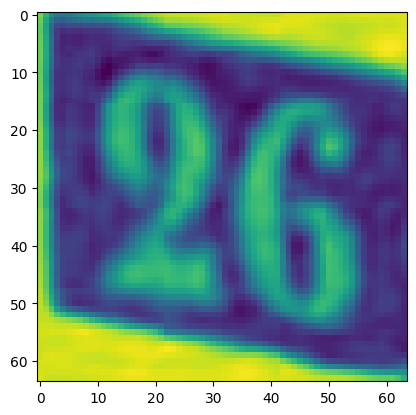

In [ ]:
plt.figure()
plt.imshow(train_dataset[70])

print(f"Label for image: {train_labels[70]}")

## Convert Labels
This function converts each digit label to one-hot array.

In [ ]:
# Converting labels to One-hot representations of shape (set_size, digits, classes)
possible_classes = 11

def convert_labels(labels):
    
    # As per Keras conventions, the multiple labels need to be of the form [array_digit1,...5]
    # Each digit array will be of shape (60000,11)
        
    # Declare output ndarrays
    # 5 for digits, 11 for possible classes  
    dig0_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig1_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig2_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig3_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig4_arr = np.ndarray(shape=(len(labels),possible_classes))
    
    for index,label in enumerate(labels):
        
        # Using utils.np_utils from keras to OHE the labels in the image
        dig0_arr[index,:] = utils.to_categorical(label[0],possible_classes)
        dig1_arr[index,:] = utils.to_categorical(label[1],possible_classes)
        dig2_arr[index,:] = utils.to_categorical(label[2],possible_classes)
        dig3_arr[index,:] = utils.to_categorical(label[3],possible_classes)
        dig4_arr[index,:] = utils.to_categorical(label[4],possible_classes)
        
    return [dig0_arr,dig1_arr,dig2_arr,dig3_arr,dig4_arr]

In [ ]:
train_labels = convert_labels(train_labels)
test_labels = convert_labels(test_labels)
valid_labels = convert_labels(valid_labels)

In [ ]:
# Checking the shape of the OHE array for the first digit position
np.shape(train_labels[0])

(27401, 11)

## Prepare Data for Keras
Reshape image data to be processed by Keras.

In [ ]:
def prep_data_keras(img_data):
    
    # Reshaping data for keras, with tensorflow as backend
    img_data = img_data.reshape(len(img_data), 64, 64, 1)
    
    # Converting everything to floats
    img_data = img_data.astype('float32')
    
    # Normalizing values between 0 and 1
    #img_data /= 255
    
    return img_data


In [ ]:
train_images = prep_data_keras(train_dataset)
test_images = prep_data_keras(test_dataset)
valid_images = prep_data_keras(valid_dataset)

In [ ]:
np.shape(train_images)

(27401, 64, 64, 1)

In [ ]:
np.shape(test_images)

(13068, 64, 64, 1)

In [ ]:
# Importing relevant keras modules
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop, Adadelta, Adam, Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard


## Build Model
Build Deep Learning model to process data.

# Performance of model on different layers of CNN

## (1) Conv1, Conv2, pooling1, Dropout, Flatten, FC,Dropout, Prediction(8 layers)


In [ ]:
# Building the model

batch_size = 128
nb_classes = 11
# nb_epoch = 24
nb_epoch = 10

# image input dimensions
img_rows = 64
img_cols = 64
img_channels = 1

# number of convulation filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

# defining the input
inputs = Input(shape=(img_rows, img_cols, img_channels))

# Model taken from keras example.
cov = Conv2D(nb_filters,kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(inputs)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D(nb_filters,kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)


cov_out = Flatten()(cov)


# Dense Layers
cov2 = Dense(2056, activation='relu')(cov_out)
cov2 = Dropout(0.3)(cov2)


# Prediction layers
c0 = Dense(nb_classes, activation='softmax')(cov2)
c1 = Dense(nb_classes, activation='softmax')(cov2)
c2 = Dense(nb_classes, activation='softmax')(cov2)
c3 = Dense(nb_classes, activation='softmax')(cov2)
c4 = Dense(nb_classes, activation='softmax')(cov2)

# Defining the model
model = Model(inputs=inputs,outputs=[c0,c1,c2,c3,c4])
# print (model.summary())


# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
    
# Fitting the model
model.fit(train_images,train_labels,batch_size=batch_size,epochs=nb_epoch,verbose=1,
          validation_data=(valid_images, valid_labels), callbacks=[early_stopping])

## (2) Conv1, Conv2, pooling1,Dropout, Conv3,Conv4, Pooling2, Dropout, Flatten, FC,Dropout, Prediction(12 layers)

In [ ]:
# Building the model

# below variables are already defined in starting of model building code, so it is not required to define here
# batch_size = 128
# nb_classes = 11
# # nb_epoch = 24
# nb_epoch = 10

# # image input dimensions
# img_rows = 64
# img_cols = 64
# img_channels = 1

# # number of convulation filters to use
# nb_filters = 32
# # size of pooling area for max pooling
# pool_size = (2, 2)
# # convolution kernel size
# kernel_size = (3, 3)

# # defining the input
# inputs = Input(shape=(img_rows, img_cols, img_channels))

# Model taken from keras example.
cov = Conv2D(nb_filters,kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(inputs)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D(nb_filters,kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)

cov = Conv2D((nb_filters * 2),kernel_size=(kernel_size[0],kernel_size[1]), use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D((nb_filters * 2),kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)




cov_out = Flatten()(cov)


# Dense Layers
cov2 = Dense(2056, activation='relu')(cov_out)
cov2 = Dropout(0.3)(cov2)



# Prediction layers
c0 = Dense(nb_classes, activation='softmax')(cov2)
c1 = Dense(nb_classes, activation='softmax')(cov2)
c2 = Dense(nb_classes, activation='softmax')(cov2)
c3 = Dense(nb_classes, activation='softmax')(cov2)
c4 = Dense(nb_classes, activation='softmax')(cov2)

# Defining the model
model2 = Model(inputs=inputs,outputs=[c0,c1,c2,c3,c4])
# print (model.summary())


# Compiling the model
model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
    
# Fitting the model
model2.fit(train_images,train_labels,batch_size=batch_size,epochs=nb_epoch,verbose=1,
          validation_data=(valid_images, valid_labels), callbacks=[early_stopping])

## (3) Conv1, Conv2, pooling1, Dropout, Conv3, Conv4, Pooling2, Dropout, Conv5, Conv6, Pooling3, Dropout, Conv7, Conv8, Pooling4, Dropout, Flatten, FC, Dropout, Prediction (20 layers)

In [ ]:
# Building the model

# below variables are already defined in starting of model building code, so it is not required to define here
batch_size = 128
nb_classes = 11
# nb_epoch = 24
nb_epoch = 10

# image input dimensions
img_rows = 64
img_cols = 64
img_channels = 1

# number of convulation filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

# defining the input
inputs = Input(shape=(img_rows, img_cols, img_channels))

# Model taken from keras example.
cov = Conv2D(nb_filters,kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(inputs)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D(nb_filters,kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)

cov = Conv2D((nb_filters * 2),kernel_size=(kernel_size[0],kernel_size[1]), use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D((nb_filters * 2),kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)


cov = Conv2D((nb_filters * 4),kernel_size=(kernel_size[0],kernel_size[1]), use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D((nb_filters * 4),kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)

cov = Conv2D((nb_filters * 8),kernel_size=(kernel_size[0],kernel_size[1]), use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D((nb_filters * 8),kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)

cov_out = Flatten()(cov)


# Dense Layers
cov2 = Dense(2056, activation='relu')(cov_out)
cov2 = Dropout(0.3)(cov2)



# Prediction layers
c0 = Dense(nb_classes, activation='softmax')(cov2)
c1 = Dense(nb_classes, activation='softmax')(cov2)
c2 = Dense(nb_classes, activation='softmax')(cov2)
c3 = Dense(nb_classes, activation='softmax')(cov2)
c4 = Dense(nb_classes, activation='softmax')(cov2)

# Defining the model
model3 = Model(inputs=inputs,outputs=[c0,c1,c2,c3,c4])
# print (model.summary())


# Compiling the model
model3.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
    
# Fitting the model
model3.fit(train_images,train_labels,batch_size=batch_size,epochs=nb_epoch,verbose=1,
          validation_data=(valid_images, valid_labels), callbacks=[early_stopping])

Epoch 1/10
215/215 [==============================] - 678s 3s/step - loss: 6.1771 - dense_7_loss: 2.1182 - dense_8_loss: 2.4377 - dense_9_loss: 1.3081 - dense_10_loss: 0.2971 - dense_11_loss: 0.0161 - dense_7_accuracy: 0.2613 - dense_8_accuracy: 0.1720 - dense_9_accuracy: 0.6936 - dense_10_accuracy: 0.9534 - dense_11_accuracy: 0.9962 - val_loss: 5.8441 - val_dense_7_loss: 2.0100 - val_dense_8_loss: 2.3141 - val_dense_9_loss: 1.2307 - val_dense_10_loss: 0.2868 - val_dense_11_loss: 0.0027 - val_dense_7_accuracy: 0.3310 - val_dense_8_accuracy: 0.2063 - val_dense_9_accuracy: 0.6947 - val_dense_10_accuracy: 0.9540 - val_dense_11_accuracy: 1.0000
Epoch 2/10
215/215 [==============================] - 677s 3s/step - loss: 4.0664 - dense_7_loss: 1.3280 - dense_8_loss: 1.6233 - dense_9_loss: 0.9109 - dense_10_loss: 0.2004 - dense_11_loss: 0.0038 - dense_7_accuracy: 0.5500 - dense_8_accuracy: 0.4494 - dense_9_accuracy: 0.7291 - dense_10_accuracy: 0.9578 - dense_11_accuracy: 0.9997 - val_loss: 4.7

# Performance of model for different optimizers in 20 layers 

## (1) Stochastic Gradiant Descent with momentum 

In [ ]:
# Building the model

# below variables are already defined in starting of model building code, so it is not required to define here

# batch_size = 128
# nb_classes = 11
# # nb_epoch = 24
# nb_epoch = 10

# # image input dimensions
# img_rows = 64
# img_cols = 64
# img_channels = 1

# # number of convulation filters to use
# nb_filters = 32
# # size of pooling area for max pooling
# pool_size = (2, 2)
# # convolution kernel size
# kernel_size = (3, 3)

# # defining the input
# inputs = Input(shape=(img_rows, img_cols, img_channels))

# Model taken from keras example.
cov = Conv2D(nb_filters,kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(inputs)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D(nb_filters,kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)

cov = Conv2D((nb_filters * 2),kernel_size=(kernel_size[0],kernel_size[1]), use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D((nb_filters * 2),kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)


cov = Conv2D((nb_filters * 4),kernel_size=(kernel_size[0],kernel_size[1]), use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D((nb_filters * 4),kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)

cov = Conv2D((nb_filters * 8),kernel_size=(kernel_size[0],kernel_size[1]), use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D((nb_filters * 8),kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)

cov_out = Flatten()(cov)


# Dense Layers
cov2 = Dense(2056, activation='relu')(cov_out)
cov2 = Dropout(0.3)(cov2)



# Prediction layers
c0 = Dense(nb_classes, activation='softmax')(cov2)
c1 = Dense(nb_classes, activation='softmax')(cov2)
c2 = Dense(nb_classes, activation='softmax')(cov2)
c3 = Dense(nb_classes, activation='softmax')(cov2)
c4 = Dense(nb_classes, activation='softmax')(cov2)

# Defining the model
model4 = Model(inputs=inputs,outputs=[c0,c1,c2,c3,c4])
# print (model.summary())


model4.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9), metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
    
# Fitting the model
model4.fit(train_images,train_labels,batch_size=batch_size,epochs=nb_epoch,verbose=1,
          validation_data=(valid_images, valid_labels), callbacks=[early_stopping])

## (2) Adagrad 

In [ ]:
# Building the model

# below variables are already defined in starting of model building code, so it is not required to define here
# batch_size = 128
# nb_classes = 11
# # nb_epoch = 24
# nb_epoch = 10

# # image input dimensions
# img_rows = 64
# img_cols = 64
# img_channels = 1

# # number of convulation filters to use
# nb_filters = 32
# # size of pooling area for max pooling
# pool_size = (2, 2)
# # convolution kernel size
# kernel_size = (3, 3)

# # defining the input
# inputs = Input(shape=(img_rows, img_cols, img_channels))

# Model taken from keras example.
cov = Conv2D(nb_filters,kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(inputs)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D(nb_filters,kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)

cov = Conv2D((nb_filters * 2),kernel_size=(kernel_size[0],kernel_size[1]), use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D((nb_filters * 2),kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)


cov = Conv2D((nb_filters * 4),kernel_size=(kernel_size[0],kernel_size[1]), use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D((nb_filters * 4),kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)

cov = Conv2D((nb_filters * 8),kernel_size=(kernel_size[0],kernel_size[1]), use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D((nb_filters * 8),kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)

cov_out = Flatten()(cov)


# Dense Layers
cov2 = Dense(2056, activation='relu')(cov_out)
cov2 = Dropout(0.3)(cov2)



# Prediction layers
c0 = Dense(nb_classes, activation='softmax')(cov2)
c1 = Dense(nb_classes, activation='softmax')(cov2)
c2 = Dense(nb_classes, activation='softmax')(cov2)
c3 = Dense(nb_classes, activation='softmax')(cov2)
c4 = Dense(nb_classes, activation='softmax')(cov2)

# Defining the model
model5 = Model(inputs=inputs,outputs=[c0,c1,c2,c3,c4])
# print (model.summary())


model5.compile(loss='categorical_crossentropy', optimizer=Adagrad(lr=0.01), metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
    
# Fitting the model
model5.fit(train_images,train_labels,batch_size=batch_size,epochs=nb_epoch,verbose=1,
          validation_data=(valid_images, valid_labels), callbacks=[early_stopping])

# (3) RMSprop 

In [ ]:
# Building the model

# below variables are already defined in starting of model building code, so it is not required to define here
# batch_size = 128
# nb_classes = 11
# # nb_epoch = 24
# nb_epoch = 10

# # image input dimensions
# img_rows = 64
# img_cols = 64
# img_channels = 1

# # number of convulation filters to use
# nb_filters = 32
# # size of pooling area for max pooling
# pool_size = (2, 2)
# # convolution kernel size
# kernel_size = (3, 3)

# defining the input
# inputs = Input(shape=(img_rows, img_cols, img_channels))

# Model taken from keras example.
cov = Conv2D(nb_filters,kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(inputs)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D(nb_filters,kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)

cov = Conv2D((nb_filters * 2),kernel_size=(kernel_size[0],kernel_size[1]), use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D((nb_filters * 2),kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)


cov = Conv2D((nb_filters * 4),kernel_size=(kernel_size[0],kernel_size[1]), use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D((nb_filters * 4),kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)

cov = Conv2D((nb_filters * 8),kernel_size=(kernel_size[0],kernel_size[1]), use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D((nb_filters * 8),kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)

cov_out = Flatten()(cov)


# Dense Layers
cov2 = Dense(2056, activation='relu')(cov_out)
cov2 = Dropout(0.3)(cov2)



# Prediction layers
c0 = Dense(nb_classes, activation='softmax')(cov2)
c1 = Dense(nb_classes, activation='softmax')(cov2)
c2 = Dense(nb_classes, activation='softmax')(cov2)
c3 = Dense(nb_classes, activation='softmax')(cov2)
c4 = Dense(nb_classes, activation='softmax')(cov2)

# Defining the model
model6 = Model(inputs=inputs,outputs=[c0,c1,c2,c3,c4])
# print (model.summary())


model6.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
    
# Fitting the model
model6.fit(train_images,train_labels,batch_size=batch_size,epochs=nb_epoch,verbose=1,
          validation_data=(valid_images, valid_labels), callbacks=[early_stopping])

In [ ]:
predictions =  model.predict(test_images)
predictions2 = model2.predict(test_images)
predictions3 = model3.predict(test_images)
predictions4 = model4.predict(test_images)
predictions5 = model5.predict(test_images)
predictions6 = model6.predict(test_images)

409/409 [==============================] - 61s 136ms/step


In [ ]:
print(np.shape(predictions))
print(np.shape(predictions2))
print(np.shape(predictions3))
print(np.shape(predictions4))
print(np.shape(predictions5))
print(np.shape(predictions6))

(5, 13068, 11)

In [ ]:
import os

# Directory path
directory = 'saved_model'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)
    
model.save('saved_model/cnn_model')
model2.save('saved_model/cnn_model2')
model3.save('saved_model/cnn_model3')
model4.save('saved_model/cnn_model4')
model5.save('saved_model/cnn_model5')
model6.save('saved_model/cnn_model6')

# new_model = tf.keras.models.load_model('saved_model/cnn_model')
# new_model.summary()

INFO:tensorflow:Assets written to: saved_model/cnn_model\assets


INFO:tensorflow:Assets written to: saved_model/cnn_model\assets


## Calculate Accuracy
Custom accuracy calculation for individual digits and the whole sequence.

In [ ]:
def calculate_acc(predictions,real_labels):
    
    individual_counter = 0
    global_sequence_counter = 0
    coverage_counter = 0
    confidence = 0.7
    for i in range(0,len(predictions[0])):
        # Reset sequence counter at the start of each image
        sequence_counter = 0 
        
        for j in range(0,5):
            
            if np.argmax(predictions[j][i]) == np.argmax(real_labels[j][i]):
                individual_counter += 1
                sequence_counter += 1
            if predictions[j][i][np.argmax(predictions[j][i])] >= confidence:
                coverage_counter += 1
        
        if sequence_counter == 5:
            global_sequence_counter += 1
         
    ind_accuracy = individual_counter / float(len(predictions[0]) * 5)
    global_accuracy = global_sequence_counter / float(len(predictions[0]))
    coverage = coverage_counter / float(len(predictions[0]) * 5)
    
    return ind_accuracy,global_accuracy, coverage

In [ ]:
ind_acc, glob_acc, coverage = calculate_acc(predictions, test_labels)
ind_acc2, glob_acc2, coverage2 = calculate_acc(predictions2, test_labels)
ind_acc3, glob_acc3, coverage3 = calculate_acc(predictions3, test_labels)
ind_acc4, glob_acc4, coverage4 = calculate_acc(predictions4, test_labels)
ind_acc5, glob_acc5, coverage5 = calculate_acc(predictions5, test_labels)
ind_acc6, glob_acc6, coverage6 = calculate_acc(predictions6, test_labels)

In [ ]:
# these results are for cnn with 20 layers and Adam optimizer, which is better model out of all models
print("The individual accuracy is {} %".format(ind_acc3 * 100))
print("The sequence prediction accuracy is {} %".format(glob_acc3 * 100))
print("The coverage is {} %".format(coverage3 * 100))


The individual accuracy is 95.78206305479033 %
The sequence prediction accuracy is 83.70829507193143 %
The coverage is 94.47352310988674 %


In [ ]:
# checking performance over different layers architecture of CNN
print("The individual accuracy for 8 layers is {} %".format(ind_acc * 100))
print("The sequence prediction accuracy for 8 layers is {} %".format(glob_acc * 100))
print("The coverage for 8 layers is {} %".format(coverage * 100))
print("The individual accuracy for 12 layers is {} %".format(ind_acc2 * 100))
print("The sequence prediction accuracy for 12 layers is {} %".format(glob_acc2 * 100))
print("The coverage for 12 layers is {} %".format(coverage2 * 100))
print("The individual accuracy for 20 layers is {} %".format(ind_acc3 * 100))
print("The sequence prediction accuracy for 20 layers is {} %".format(glob_acc3 * 100))
print("The coverage for 20 layers is {} %".format(coverage3 * 100))

# checking performance over different optimizers with 20 layers architechture
print("The individual accuracy for SGD with momentum  is {} %".format(ind_acc4 * 100))
print("The sequence prediction accuracy for SGD with momentum is {} %".format(glob_acc4 * 100))
print("The coverage for SGD with momentum is {} %".format(coverage4 * 100))
print("The individual accuracy for Adagrad is {} %".format(ind_acc5 * 100))
print("The sequence prediction accuracy for 8 Adagrad is {} %".format(glob_acc5 * 100))
print("The coverage for Adagrad is {} %".format(coverage5 * 100))
print("The individual accuracy for RMSprop is {} %".format(ind_acc6 * 100))
print("The sequence prediction accuracy for RMSprop is {} %".format(glob_acc6 * 100))
print("The coverage for RMSprop is {} %".format(coverage6 * 100))
print("The individual accuracy for ADAM is {} %".format(ind_acc3 * 100))
print("The sequence prediction accuracy for ADAM is {} %".format(glob_acc3 * 100))
print("The coverage for ADAM is {} %".format(coverage3 * 100))

In [ ]:
def rgb2gray(images):
    """Convert images from rbg to grayscale
    """
    greyscale = np.dot(images, [0.2989, 0.5870, 0.1140])
    return np.expand_dims(greyscale, axis=2)

In [ ]:
# img = input()
img = "image3.jpg"
image = Image.open(img)
image_size = (64, 64)
resize_img = np.array(image.resize((image_size[0], image_size[1]), Image.ANTIALIAS))
grey_img = rgb2gray(resize_img).astype(np.float32)
expanded_img = np.expand_dims(grey_img, axis=0)
processed_img = prep_data_keras(expanded_img)

C:\Users\abhi\AppData\Local\Temp\ipykernel_17384\536675504.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resize_img = np.array(image.resize((image_size[0], image_size[1]), Image.ANTIALIAS))


In [ ]:
model7 = load_model("/content/drive/MyDrive/saved_model/cnn_model1")

In [ ]:
predictions = model7.predict(processed_img)

1/1 [==============================] - 0s 36ms/step


In [ ]:
predicted_digits = ""
for i in range(5):
    digit = np.argmax(predictions[i][0])
    predicted_digits += str(digit) + " " if digit != 10 else ""
print(f'The predicted number sequence: {predicted_digits.strip(" ")}')

The predicted number sequence: 5 5 0
